In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-bank/train_s3TEQDk.csv
/kaggle/input/customer-bank/sample_submission_eyYijxG.csv
/kaggle/input/customer-bank/test_mSzZ8RL.csv


# _Credit Card Lead Prediction_
***
Happy Customer Bank is a mid-sized private bank that deals in all kinds of banking products, like Savings accounts, Current accounts, investment products, credit products, among other offerings.

The bank also cross-sells products to its existing customers and to do so they use different kinds of communication like tele-calling, e-mails, recommendations on net banking, mobile banking, etc. 

In this case, the Happy Customer Bank wants to cross sell its credit cards to its existing customers. The bank has identified a set of customers that are eligible for taking these credit cards.

Now, the bank is looking for your help in identifying customers that could show higher intent towards a recommended credit card, given:
- Customer details (gender, age, region etc.)
- Details of his/her relationship with the bank (Channel_Code,Vintage, 'Avg_Asset_Value etc.)

<b> Data Dictionary </b>

- ID - Unique Identifier for a row

- Gender - Gender of the Customer

- Age - Age of the Customer (in Years)

- Region_Code - Code of the Region for the customers

- Occupation - Occupation Type for the customer

- Channel_Code - Acquisition Channel Code for the Customer  (Encoded)

- Vintage - Vintage for the Customer (In Months)

- Credit_Product - If the Customer has any active credit product (Home loan,Personal loan, Credit Card etc.)

- Avg_Account_Balance - Average Account Balance for the Customer in last 12 Months

- Is_Active - If the Customer is Active in last 3 Months

- Is_Lead(Target) - If the Customer is interested for the Credit Card

0 : Customer is not interested

1 : Customer is interested

# _Import Libraries and Load the Data_

In [2]:
#system specific
import os
import sys
#string operations
import string
import re
#assert the python version to be used
assert sys.version_info >= (3,5)
#data load and data operations
import numpy as np
import pandas as pd
#visualization and exploration
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#consistent plots
from pylab import rcParams
rcParams['figure.figsize']= 12,5
rcParams['axes.labelsize']=12
rcParams['xtick.labelsize']=12
rcParams['ytick.labelsize']=12
#pandas auto profiler
import pandas_profiling as pp
#view all the data columns
pd.options.display.max_columns = None
#handle unwanted warnings
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

## _Load the data_

In [3]:
#load the data into pandas dataframe
train_orig = pd.read_csv('/kaggle/input/customer-bank/train_s3TEQDk.csv',delimiter=',',engine='python')
test_orig =  pd.read_csv('/kaggle/input/customer-bank/test_mSzZ8RL.csv',delimiter=',',engine='python')
submission_orig = pd.read_csv('/kaggle/input/customer-bank/sample_submission_eyYijxG.csv',delimiter=',',engine='python')

In [4]:
#create a copy of the original dataset
train = train_orig.copy()
test = test_orig.copy()

## _Exploratory Data Analysis_

In [5]:
#view the top few rows
train.head(10)

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0
5,ACUTYTWS,Male,56,RG261,Self_Employed,X1,32,No,544163,Yes,0
6,ETQCZFEJ,Male,62,RG282,Other,X3,20,NaN,1056750,Yes,1
7,JJNJUQMQ,Female,48,RG265,Self_Employed,X3,13,No,444724,Yes,0
8,ZMQFYKCB,Female,40,RG283,Self_Employed,X2,38,No,1274284,No,0
9,NVKTFBA2,Female,55,RG268,Self_Employed,X2,49,Yes,2014239,No,0


In [6]:
#check the last few rows
train.tail()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
245720,BPAWWXZN,Male,51,RG284,Self_Employed,X3,109,NaN,1925586,No,0
245721,HFNB7JY8,Male,27,RG268,Salaried,X1,15,No,862952,Yes,0
245722,GEHAUCWT,Female,26,RG281,Salaried,X1,13,No,670659,No,0
245723,GE7V8SAH,Female,28,RG273,Salaried,X1,31,No,407504,No,0
245724,BOCZSWLJ,Male,29,RG269,Salaried,X1,21,No,1129276,No,0


In [7]:
#check the info 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


_Except for the Credit_Product feature, all other features and target variables do not have null values. For a faster exploration of all the features, pandas profile report would be helpful._

In [8]:
#check basic stats of the numerical features
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,245725.0,4.385631e+01,14.828672,23.0,30.0,43.0,54.0,85.0
Vintage,245725.0,4.695914e+01,32.353136,7.0,20.0,32.0,73.0,135.0
Avg_Account_Balance,245725.0,1.128403e+06,852936.356069,20790.0,604310.0,894601.0,1366666.0,10352009.0
Is_Lead,245725.0,2.372083e-01,0.425372,0.0,0.0,0.0,0.0,1.0


### _Generate Pandas Profile Report_

In [9]:
#generate profile report for the train data
pp.ProfileReport(train)

Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<b> _The ID variable is not to be used for prediction. Hence it can be dropped. Secondly, the profile report and the info clearly reflects that there are no duplicate customer records in the dataset. However, just to be sure, lets convert the ID column to lower case and check if there are still duplicates_ </b>

In [10]:
#check for duplicates in the ID column
train['ID'] = train['ID'].str.lower()
train['ID'].duplicated().any()

False

<b> _There are no duplicate customer ID's in the dataset_ </b>

In [11]:
#drop the ID column from the analysis 
train.drop('ID',axis=1,inplace=True)
#drop the column from the test dataset 
test.drop('ID',axis=1,inplace=True)

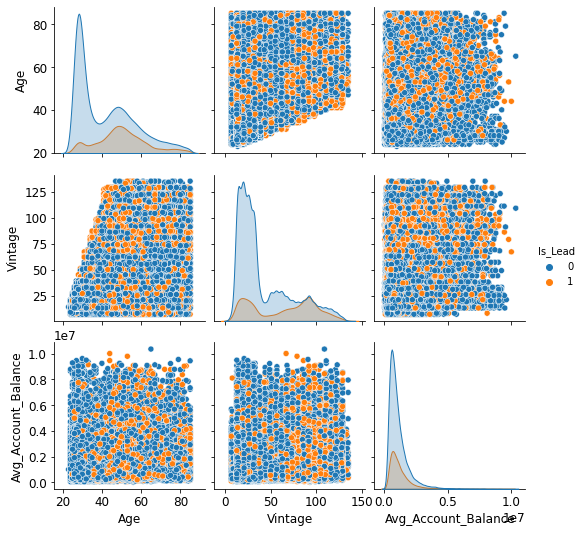

In [12]:
#create pair plot
sns.pairplot(data=train,hue='Is_Lead',diag_kind='kde')
plt.show()

_The kde plots on the diagonal are throwing some interesting insight on the data._
- _The Age feature clearly has clusters of more rightly bins. One age group is younger between 20 to 40 years of age while the other is 40 to 60 years of Age. There are also customer 60 and 80 years of age but their numbers are not as high compared to the younger age groups.Secondly, those in the 40 to 60 age range have leads whereas the younger ones are not.Perhaps, this could be associated with the Vintage which would be more visible for the higher age group_

- <b> _Vintage_ </b> _is a colloquial term used to describe mortgage-backed securities (MBS) that have been "seasoned." That is, they've been issued long enough, and enough on-time payments have been made, that the risk of default is lower. Vintage is the age of an item as it relates to the year it was created._ _Lower vintages has more 1 credit card lead while the higher values have not. Could it be that the one who have higher vintage would be least interested to go for a credit card as they might have funds already after a number of on time payments have been made_

- _The average account balance for both the leads 0 and 1 appears to be similar and currently appears not to be one of the main deciding feature to classify the credit card lead_

- <font color = 'blue'> <b> _The kde plot on the diagonal for the Age and Vintage clearly indicates there are separate clusters in the data and separate models based on these clusters can also be a viable option for actual production_</b> </font>



<b>_Credit product_</b> _feature has a lot of missing values. As per the meta data, this feature reflects any active credit product like home loan, personal loan or credit card that the customer already has. The feature is boolean and it is difficult to make a choice for these customers where the data is missing._

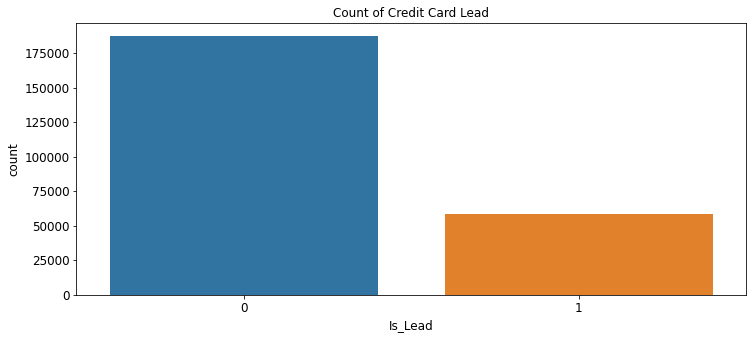

In [13]:
#check the balance of the data wrt the target feature
sns.countplot('Is_Lead',data=train)
plt.title('Count of Credit Card Lead')
plt.show()

In [14]:
#check the exact number of target labels per class
train['Is_Lead'].value_counts().sort_values(ascending=False)

0    187437
1     58288
Name: Is_Lead, dtype: int64

_The number of leads is roughly 31% of the customer without credit card lead. The data is imbalanced as expected. The split of the data can be based on stratification methodology to have similar representation in the train and validation split_

In [15]:
#create separate list of numerical and categorical features
cat_features = train.select_dtypes(include='object').columns.to_list()
num_features = train.select_dtypes(exclude='object').columns.to_list()

In [16]:
#check the unique value counts per categorical feature
for col in cat_features:
    print('\n')
    print(train[col].value_counts().sort_values(ascending=False))



Male      134197
Female    111528
Name: Gender, dtype: int64


RG268    35934
RG283    29416
RG254    26840
RG284    19320
RG277    12826
RG280    12775
RG269     7863
RG270     7720
RG261     7633
RG257     6101
RG251     5950
RG282     5829
RG274     5286
RG272     5252
RG281     5093
RG273     4497
RG252     4286
RG279     3976
RG263     3687
RG275     3245
RG260     3110
RG256     2847
RG264     2793
RG276     2764
RG259     2586
RG250     2496
RG255     2018
RG258     1951
RG253     1858
RG278     1822
RG262     1788
RG266     1578
RG265     1546
RG271     1542
RG267     1497
Name: Region_Code, dtype: int64


Self_Employed    100886
Salaried          71999
Other             70173
Entrepreneur       2667
Name: Occupation, dtype: int64


X1    103718
X3     68712
X2     67726
X4      5569
Name: Channel_Code, dtype: int64


No     144357
Yes     72043
Name: Credit_Product, dtype: int64


No     150290
Yes     95435
Name: Is_Active, dtype: int64


- _There are quite a lot of customers who are not active in the last 3 months compared to those who are active_
- _There are much more customers without any credit product compared to the ones that have it_
- _Self employed customers followed by salaried form the majority_


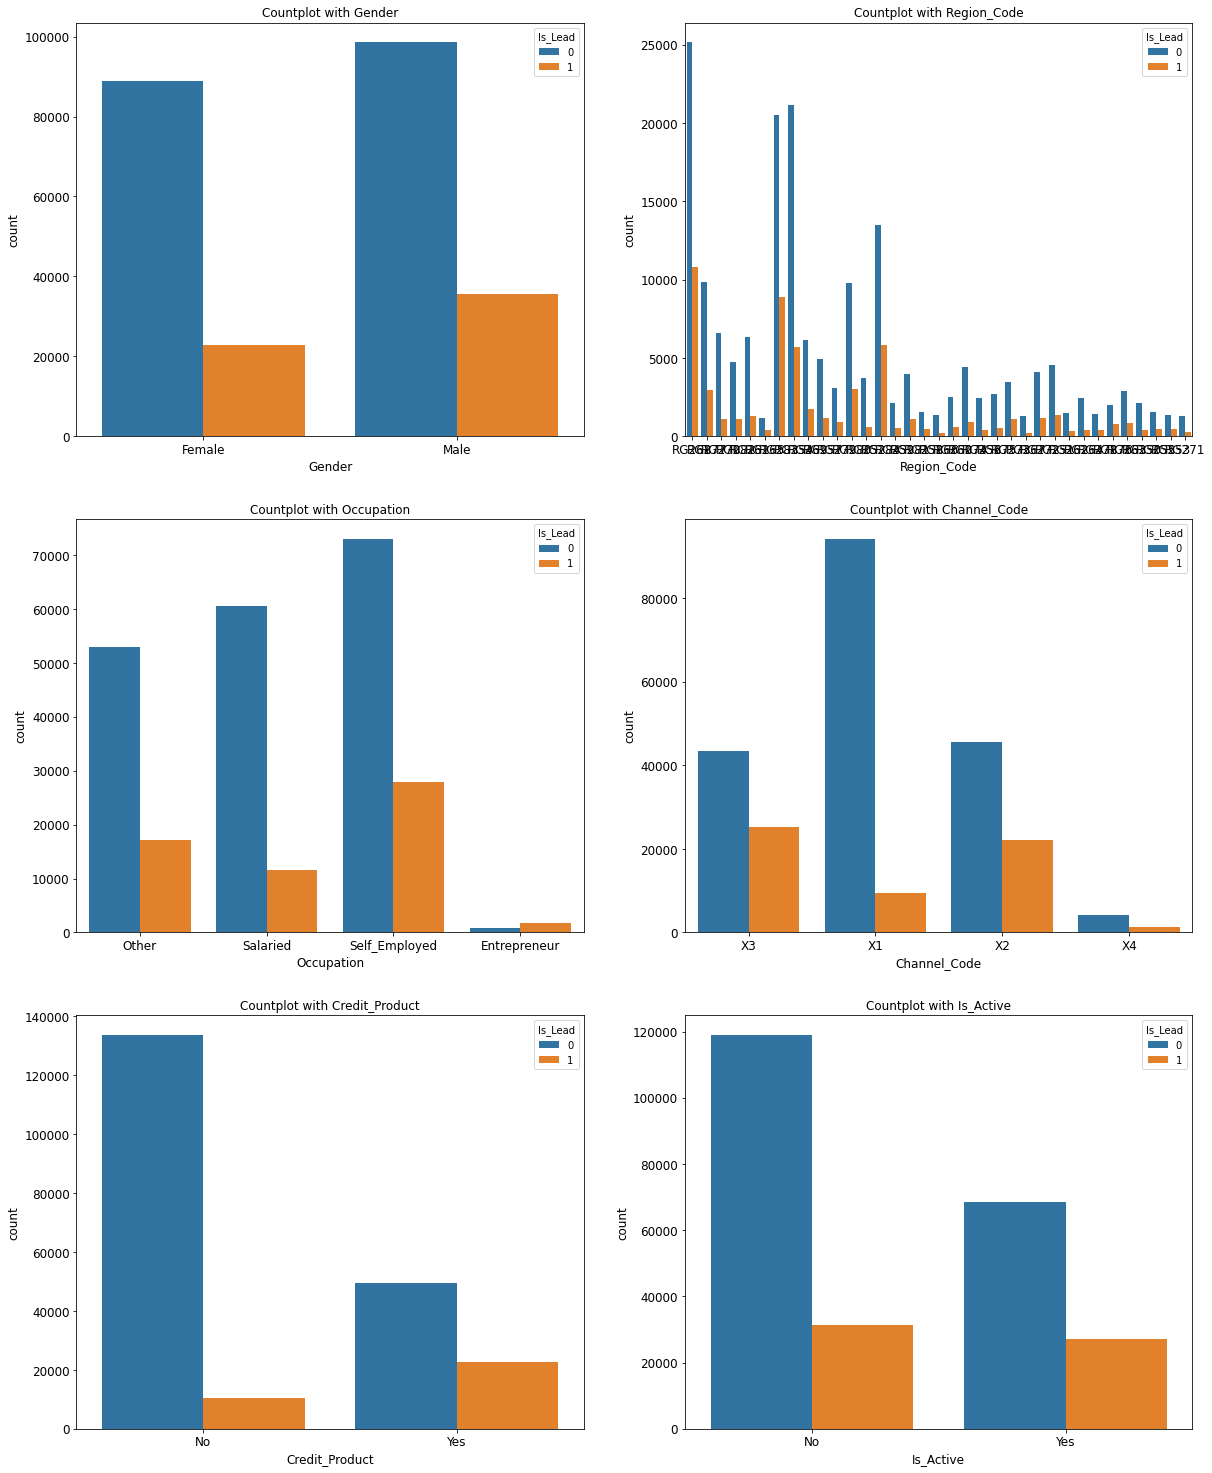

In [17]:
#countplot of all the categorical features 
fig = plt.figure(figsize=(20, 35))
for index, col in enumerate(cat_features):
    plt.subplot(4, 2, index+1)
    sns.countplot(data=train, x=col,hue='Is_Lead') 
    plt.title('Countplot with '+col)

_Following observations can be derived from the countplot_
- _The proportion of leads for customers with a credit product is higher compared to those who do not have a credit product_
- _The proportion of leads for active customers is higher compared to the non active customers_
- _Channel code X3 and X2 have higher positive leads compared to the other channels_ 
- _The gender of the customer does not really matter in deciding who has a better lead_ 
- _Some of the region codes contribute to the maximum positive credit card leads_

In [18]:
#check the numerical features
num_features

['Age', 'Vintage', 'Avg_Account_Balance', 'Is_Lead']

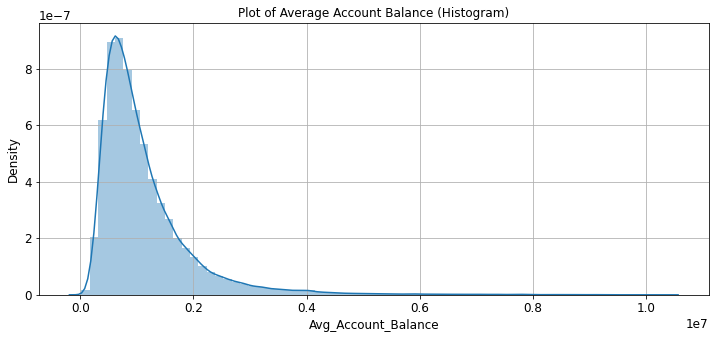

In [19]:
sns.distplot(train['Avg_Account_Balance'],bins=70)
plt.title('Plot of Average Account Balance (Histogram)')
plt.grid()
plt.show()

_The average account balance as expected is right skewed_

In [20]:
#test for normality -- > clearly the data is not normal
from scipy.stats import shapiro
stats,p = shapiro(train['Avg_Account_Balance'])
print('p-value for the Shapiro wilk test %.3f'% (p))
if p>0.05:
    
    print('Data is probably Gaussian')
else:
    print('Data is probably not Gaussian')

p-value for the Shapiro wilk test 0.000
Data is probably not Gaussian


/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


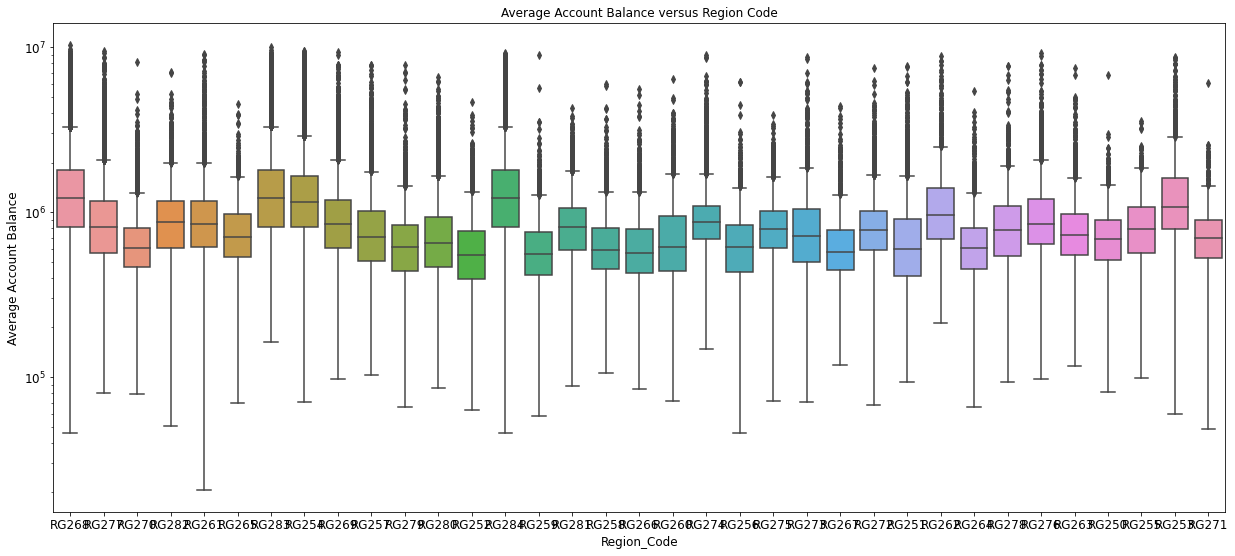

In [21]:
#boxplot of the avg account balance vs the region code
plt.figure(figsize=(21,9))
sns.boxplot(x= 'Region_Code',y='Avg_Account_Balance',data=train)
plt.title(f'Average Account Balance versus Region Code')
plt.ylabel('Average Account Balance')
plt.yscale('log')
plt.show()

_There is strong variation of the average account balance based on the region code_

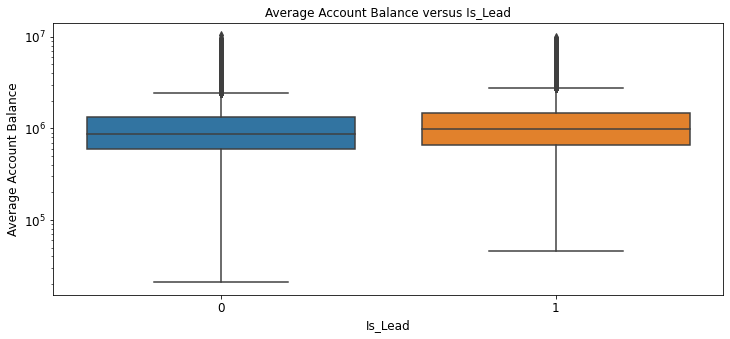

In [22]:
#boxplot of the avg account balance vs the region code
sns.boxplot(x= 'Is_Lead',y='Avg_Account_Balance',data=train)
plt.title(f'Average Account Balance versus Is_Lead')
plt.ylabel('Average Account Balance')
plt.yscale('log')
plt.show()

_The median account balance of the customer is higher for the customer who are positive leads for a credit card_

In [23]:
#check the correlation
train[['Age','Vintage','Avg_Account_Balance']].corr()

,Age,Vintage,Avg_Account_Balance
Age,1.000000,0.631242,0.145232
Vintage,0.631242,1.000000,0.167433
Avg_Account_Balance,0.145232,0.167433,1.000000


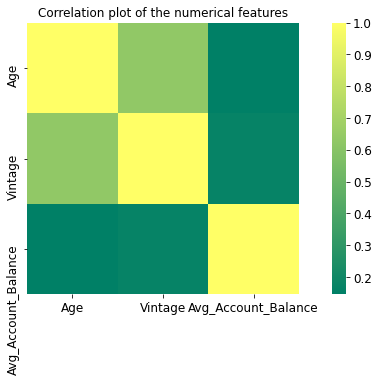

In [24]:
#visualise the correlation 
sns.heatmap(train[['Age','Vintage','Avg_Account_Balance']].corr(),square=True,cmap='summer')
plt.title('Correlation plot of the numerical features')
plt.show()

_Age and Vintage have high correlation while it cannot be said for the other features_

#### _Test whether the customer lead and the region code related_

In [25]:
#create a cross table of region code and credit card lead
region_code_lead = train.groupby(['Region_Code','Is_Lead']).size().unstack().fillna(0)
region_code_lead

Is_Lead,0,1
Region_Code,,
RG250,2103,393
RG251,4569,1381
RG252,3694,592
RG253,1377,481
RG254,21127,5713
RG255,1549,469
RG256,2446,401
RG257,4931,1170
RG258,1521,430


#### _Chi-Square Test_

In [26]:
#chi-square test
from scipy.stats import chi2_contingency

def chisq_of_df_cols(df, c1, c2):
    '''
    The function performs the chi-square test between two categorical features
    Arguments: dataframe df, columns c1 and c2
    Returns: Chi-square test parameters critical stat, p-value,degrees of freedom and expected
    '''
    groupsizes = df.groupby([c1, c2]).size()
    ctsum = groupsizes.unstack(c1)
    return(chi2_contingency(ctsum.fillna(0)))

#perform chi square test on the categorical features
stat, p, dof, expected = chisq_of_df_cols(train, 'Region_Code', 'Is_Lead')

#determine whether dependent or independent based on the p-value
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=3913.670, p=0.000
Probably dependent


<b> _Customer credit card lead and region code are dependent according to the chi-square test_ </b>

In [27]:
#chi square test between occupation and is lead
stat, p, dof, expected = chisq_of_df_cols(train, 'Credit_Product', 'Is_Lead')

#determine whether dependent or independent based on the p-value
print('stat=%.3f, p=%.5f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')


stat=21494.009, p=0.00000
Probably dependent


<b> _Is Lead is also dependent on the occupation of the customer. While this was apparent from the earlier countplots, the statistical test also proves it to be significant_ </b>

## _Data Preparation_

In [28]:
#check the data
train.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,Female,30,RG282,Salaried,X1,33,No,886787,No,0


<b> 
One of the key challenge is to deal with the missing values in the credit_product feature.The missing value is roughly 11% of the entire train dataset size.

Options that can be explored
- _drop all the rows with the missing values_
- _impute with the mode or most frequent values. this won't be a wise choice considering that the feature is boolean and can have a strong impact on the model performance. Also, the choice of imputation has to tally well with the stakeholders going to make use of this model. Hence without consulting with the business, this could be a dangerous choice_
- _Impute using KNNImpute method, would be safer than other options but again will not be fool proof_
- _Predict the class of the credit product using all of the other labels except the Is_Lead as we would also need to do so for the test dataset_
- _Lastly, have a separate label for the missing values. This can be handled during the label encoding_



</b>

### _Split the dataset_

In [29]:
#define a seed to be used
seed = 51
test_ratio = 0.2

In [30]:
#split into the train and validation test
from sklearn.model_selection import train_test_split
#split based on stratified on the Is_Lead to have similar representation in train and test data
train_set,valid_set = train_test_split(train,test_size=test_ratio,random_state=seed,stratify=train['Is_Lead'])
#print the shape of the split data
print(train_set.shape,valid_set.shape)

(196580, 10) (49145, 10)


In [31]:
#check the proportion split in the train set 
train_set['Is_Lead'].value_counts() / len(train_set)

0    0.762794
1    0.237206
Name: Is_Lead, dtype: float64

In [32]:
#check the proportion split in the valid set 
valid_set['Is_Lead'].value_counts() / len(valid_set)

0    0.762784
1    0.237216
Name: Is_Lead, dtype: float64

_The split is the train and valid set is similar with respect to the target class_

In [33]:
train_set.head(3)

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
141578,Female,33,RG283,Salaried,X1,32,NaN,1504491,Yes,0
78168,Male,40,RG283,Self_Employed,X2,27,Yes,1441622,Yes,0
211965,Male,38,RG280,Salaried,X1,19,No,400651,No,0


In [34]:
#cut the Age feature into categorical bins 
train_set['Age_Category'] = pd.cut(train_set['Age'],bins=[20,40,60,80,90])
valid_set['Age_Category'] = pd.cut(valid_set['Age'],bins=[20,40,60,80,90])
test['Age_Category'] = pd.cut(test['Age'],bins=[20,40,60,80,90])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
train_set.head(2)

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,Age_Category
141578,Female,33,RG283,Salaried,X1,32,NaN,1504491,Yes,0,"(20, 40]"
78168,Male,40,RG283,Self_Employed,X2,27,Yes,1441622,Yes,0,"(20, 40]"


In [36]:
#drop the redundant Age feature
train_set.drop('Age',axis=1,inplace=True)
valid_set.drop('Age',axis=1,inplace=True)
test.drop('Age',axis=1,inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [37]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196580 entries, 141578 to 113641
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   Gender               196580 non-null  object  
 1   Region_Code          196580 non-null  object  
 2   Occupation           196580 non-null  object  
 3   Channel_Code         196580 non-null  object  
 4   Vintage              196580 non-null  int64   
 5   Credit_Product       173091 non-null  object  
 6   Avg_Account_Balance  196580 non-null  int64   
 7   Is_Active            196580 non-null  object  
 8   Is_Lead              196580 non-null  int64   
 9   Age_Category         196580 non-null  category
dtypes: category(1), int64(3), object(6)
memory usage: 15.2+ MB


In [38]:
#split the shuffled data into train and target features
X_train = train_set.drop('Is_Lead',axis=1)
y_train = train_set['Is_Lead']

X_valid = valid_set.drop('Is_Lead',axis=1)
y_valid = valid_set['Is_Lead']

#### _Label encode the categorical features_

In [39]:
#remove the credit product from the cat features to prevent encoding null values 
cat_features = X_train.select_dtypes(include=['object','category']).columns.to_list()
#cat_features.remove('Credit_Product')

In [40]:
cat_features

['Gender',
 'Region_Code',
 'Occupation',
 'Channel_Code',
 'Credit_Product',
 'Is_Active',
 'Age_Category']

In [41]:
#label encode the categorical features
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
#encode all the cat features
warnings.filterwarnings(action='ignore',message='')
for col in cat_features:
    X_train[col] = encoder.fit_transform(X_train[col])
    X_valid[col] = encoder.transform(X_valid[col])
    test[col] = encoder.transform(test[col])
X_train.head()

,Gender,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Age_Category
141578,0,33,2,0,32,2,1504491,1,0
78168,1,33,3,1,27,1,1441622,1,0
211965,1,30,2,0,19,0,400651,0,0
138138,1,1,3,1,37,0,393477,1,1
78509,1,2,3,0,25,0,2094063,0,0


_Important to note that the missing values in Credit_Product got encoded to a different value. Instead of imputing with the most frequent value using simple imputer would not have been a reasonable choice unless it is advocated by the bank_

_Another standby option is to use the <b> iterative imputer</b> which would first require the column to be changed to integer type and then iterative apply regression technique to impute the missing values._

In [42]:
test.head(2)

,Gender,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Age_Category
0,1,4,1,0,25,1,742366,0,0
1,1,18,1,1,49,2,925537,0,1


In [43]:
test['Gender'].unique()

array([1, 0])

### _Power Transformation & Scaling_


In [44]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
pt = PowerTransformer()
scaler = StandardScaler()

#apply the transformation
X_train = pt.fit_transform(X_train)
X_valid = pt.transform(X_valid)
test = pt.transform(test)
#apply the scaling
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
test = scaler.transform(test)

In [45]:
#check shape of y_train
y_train.shape

(196580,)

_Rank-1 array can lead to serious bugs in modeling and production. Reshape it to proper 2D array with the second dimension as 1_

In [46]:
#reshape the target array 
y_train = y_train.values
y_valid = y_valid.values
y_train = y_train.reshape(y_train.shape[0],1)
y_valid = y_valid.reshape(y_valid.shape[0],1)
print(y_train.shape,y_valid.shape)

(196580, 1) (49145, 1)


### _Dimensionality Reduction_
_So far all of the features are included and no feature engineering steps are performed specifically. While dimensionality reduction using PCA would help to remove the redundant feature, the performance of the model cannot be guranteed to be improved._

In [47]:
from sklearn.decomposition import PCA
num_components = [2,3,4,5,6]
#check the total explained variance ratio using different number of principal components 
for comp in num_components:
    pca = PCA(n_components=comp)
    X_train_pca = pca.fit_transform(X_train)
    print('Total Explained Variance Ratio using {} components = {}'.format(comp,np.sum(pca.explained_variance_ratio_)))

Total Explained Variance Ratio using 2 components = 0.45794321222789247
Total Explained Variance Ratio using 3 components = 0.5826621800174765
Total Explained Variance Ratio using 4 components = 0.7057452184123625
Total Explained Variance Ratio using 5 components = 0.8208645233514449
Total Explained Variance Ratio using 6 components = 0.9104253701111286


In [48]:
#apply the pca transformation
pca = PCA(n_components=6)
X_train = pca.fit_transform(X_train)
X_valid = pca.transform(X_valid)
test = pca.transform(test)

## _Modeling_
- _Select the best classifier based on cross validation_ 
- _Fine tune the model using Grid or Randomized search_ 
- _Fit the model and predict on the validation set_ 
- _Check performance and further optimize_ 

In [49]:
#import the ML libraries
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
#libraries for cross validation 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
#evaluation metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [50]:
#define a function to run cross validation across ML algos on the dataset 
def cross_validation(X=X_train,y=y_train,score='roc_auc'):
    '''Helper Function to perform cross validation
       Arguments:X and y values (input and target feature)
       Return value: Selected score for evaluating the model'''
    seed=51
    warnings.filterwarnings(action='ignore',message='')
    
    models = []
    models.append(('Logistic Regression',LogisticRegression()))
    models.append(('Random Forest',RandomForestClassifier()))
    
    #store results
    results = []
    names = []
    
    for name,model in models:
        kfold = RepeatedStratifiedKFold(n_splits=5,random_state=seed,n_repeats=5)
        cv_results = cross_val_score(model,X,y,cv=kfold,scoring=score)
        print(f'Model {model}, {score}: {np.mean(cv_results)}')       
    

In [51]:
#perform cross validation and print score for all selected models in the function
cross_validation(X_train,y_train)

Model LogisticRegression(), roc_auc: 0.8380731418300346
Model RandomForestClassifier(), roc_auc: 0.8245860315723226


### _Fine tune the model_

In [52]:
from sklearn.model_selection import GridSearchCV

rf_clf = RandomForestClassifier()
grid_params = {'n_estimators':[300,500],'max_features':[0.5],
              'criterion':['entropy'],'oob_score':[True]}

#grid search 
grid_search = GridSearchCV(estimator=rf_clf,param_grid=grid_params,cv=5,scoring='roc_auc',return_train_score=True,verbose=2)
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END criterion=entropy, max_features=0.5, n_estimators=300, oob_score=True; total time= 3.9min
[CV] END criterion=entropy, max_features=0.5, n_estimators=300, oob_score=True; total time= 3.9min
[CV] END criterion=entropy, max_features=0.5, n_estimators=300, oob_score=True; total time= 3.9min
[CV] END criterion=entropy, max_features=0.5, n_estimators=300, oob_score=True; total time= 3.9min
[CV] END criterion=entropy, max_features=0.5, n_estimators=300, oob_score=True; total time= 3.9min
[CV] END criterion=entropy, max_features=0.5, n_estimators=500, oob_score=True; total time= 6.5min
[CV] END criterion=entropy, max_features=0.5, n_estimators=500, oob_score=True; total time= 6.4min
[CV] END criterion=entropy, max_features=0.5, n_estimators=500, oob_score=True; total time= 6.5min
[CV] END criterion=entropy, max_features=0.5, n_estimators=500, oob_score=True; total time= 6.5min
[CV] END criterion=entropy, max_features=0.5, n_e

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy'], 'max_features': [0.5],
                         'n_estimators': [300, 500], 'oob_score': [True]},
             return_train_score=True, scoring='roc_auc', verbose=2)

In [53]:
grid_search.best_estimator_

RandomForestClassifier(criterion='entropy', max_features=0.5, n_estimators=500,
                       oob_score=True)

In [54]:
#instantiate a new model based on the best model hyperparameters and fit on the train data 
from sklearn.base import clone
model = clone(grid_search.best_estimator_)
model.fit(X_train,y_train)
train_predictions = model.predict(X_train)
valid_predictions = model.predict(X_valid)

In [55]:
#classification report on the train and validation set 
print(classification_report(y_train,train_predictions))
print(classification_report(y_valid,valid_predictions))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95    149950
           1       0.89      0.74      0.81     46630

    accuracy                           0.92    196580
   macro avg       0.91      0.85      0.88    196580
weighted avg       0.91      0.92      0.91    196580

              precision    recall  f1-score   support

           0       0.87      0.92      0.90     37487
           1       0.70      0.57      0.63     11658

    accuracy                           0.84     49145
   macro avg       0.79      0.75      0.76     49145
weighted avg       0.83      0.84      0.84     49145



In [56]:
#roc auc score on the train and validation set 
print(roc_auc_score(y_train,train_predictions))
print(roc_auc_score(y_valid,valid_predictions))

0.853727817772126
0.7490925978831808


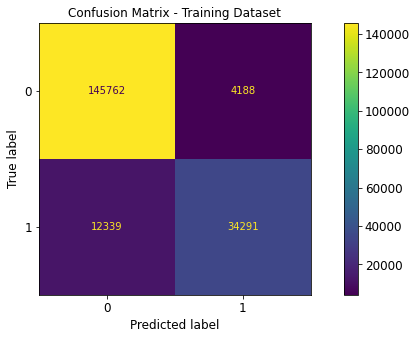

In [57]:
#plot the confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model,X_train,y_train)
plt.title('Confusion Matrix - Training Dataset')
plt.show()

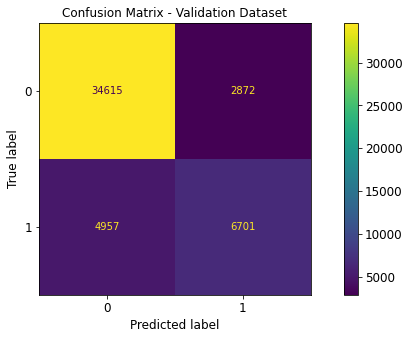

In [58]:
#plot the confusion matrix
plot_confusion_matrix(model,X_valid,y_valid)
plt.title('Confusion Matrix - Validation Dataset')
plt.show()

In [59]:
#concatenate to recreate the entire training data for final training and prediction 
X =  np.vstack((X_train,X_valid))
y =  np.vstack((y_train,y_valid))

In [62]:
X.shape,y.shape

((245725, 6), (245725, 1))

## _Deep Learning Model_

In [63]:
#import the required tensorflow keras libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
#keras wrapper for scikit learn to perform cross validation or grid search
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [64]:
#define the model --> required for the Keras Classifier class 
def create_model(optimizer='adam',init='glorot_uniform',dropout=0.0):
    model = Sequential()
    #add the layers
    model.add(Dense(units=500,input_dim=X_train.shape[1],activation='relu',kernel_initializer=init))
    model.add(Dense(units=300,activation='relu',kernel_initializer=init))
    model.add(Dropout(dropout))
    model.add(Dense(units=100,activation='relu',kernel_initializer=init))
    model.add(Dropout(dropout))
    model.add(Dense(units=50,activation='relu',kernel_initializer=init))
    model.add(Dropout(dropout))
    model.add(Dense(units=1,activation='sigmoid',kernel_initializer=init))
    #compile the model
    model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    #return the model
    return model

In [65]:
#define the early stop criteria
early_stop = EarlyStopping(monitor='val_loss',patience=50,restore_best_weights=True)
#create the model
model = KerasClassifier(build_fn=create_model,epochs=100,batch_size=16,verbose=0)
#parameters to search 
#optimizers = ['rmsprop','adam','nadam']
#define the param grid for grid search
#param_grid = dict(optimizer=optimizers)
#grid = GridSearchCV(estimator=model,param_grid=param_grid,cv=3)

In [66]:
#perform grid search 
#grid_result = grid.fit(X_train,y_train)

In [67]:
#summarize the results
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']

In [68]:
#check the mean score with all the tested optmizers
#print('Mean Accuracy:= RMSProp:%.5f, Adam:%.5f, Nadam:%.5f'%(means[0],means[1],means[2]))
#print('Standard Dev Accuracy:= RMSProp:%.5f, Adam:%.5f, Nadam:%.5f'%(stds[0],stds[1],stds[2]))

In [69]:
model = create_model(optimizer='adam',dropout=0.25)
history = model.fit(X_train,y_train,epochs=200,callbacks=[early_stop],validation_data=(X_valid,y_valid),
          verbose=2)

Epoch 1/200
6144/6144 - 17s - loss: 0.3872 - accuracy: 0.8362 - val_loss: 0.3597 - val_accuracy: 0.8537
Epoch 2/200
6144/6144 - 15s - loss: 0.3655 - accuracy: 0.8526 - val_loss: 0.3594 - val_accuracy: 0.8496
Epoch 3/200
6144/6144 - 16s - loss: 0.3611 - accuracy: 0.8550 - val_loss: 0.3522 - val_accuracy: 0.8589
Epoch 4/200
6144/6144 - 15s - loss: 0.3587 - accuracy: 0.8559 - val_loss: 0.3527 - val_accuracy: 0.8587
Epoch 5/200
6144/6144 - 16s - loss: 0.3584 - accuracy: 0.8555 - val_loss: 0.3546 - val_accuracy: 0.8543
Epoch 6/200
6144/6144 - 15s - loss: 0.3576 - accuracy: 0.8565 - val_loss: 0.3509 - val_accuracy: 0.8591
Epoch 7/200
6144/6144 - 16s - loss: 0.3568 - accuracy: 0.8566 - val_loss: 0.3515 - val_accuracy: 0.8594
Epoch 8/200
6144/6144 - 16s - loss: 0.3568 - accuracy: 0.8566 - val_loss: 0.3515 - val_accuracy: 0.8593
Epoch 9/200
6144/6144 - 16s - loss: 0.3567 - accuracy: 0.8564 - val_loss: 0.3511 - val_accuracy: 0.8593
Epoch 10/200
6144/6144 - 16s - loss: 0.3563 - accuracy: 0.8566 -

In [70]:
valid_predictions = model.predict_classes(X_valid)

In [71]:
model_score = model.evaluate(X_valid,y_valid,verbose=1)
print('%s: %.2f%% ' %(model.metrics_names[1],model_score[1]*100 ))

1536/1536 [==============================] - 3s 2ms/step - loss: 0.3479 - accuracy: 0.8594
accuracy: 85.94% 


In [72]:
print(classification_report(y_valid,valid_predictions))

              precision    recall  f1-score   support

           0       0.86      0.98      0.91     37487
           1       0.86      0.48      0.62     11658

    accuracy                           0.86     49145
   macro avg       0.86      0.73      0.77     49145
weighted avg       0.86      0.86      0.84     49145



In [73]:
#confusion matrix
print('confusion matrix of the dense neural n/w with dropout enabled')
print(confusion_matrix(y_valid,valid_predictions))

confusion matrix of the dense neural n/w with dropout enabled
[[36585   902]
 [ 6010  5648]]


In [74]:
#roc auc score on the train and validation set 
print(roc_auc_score(y_train,train_predictions))
print(roc_auc_score(y_valid,valid_predictions))

0.853727817772126
0.7302062530530684


In [75]:
model.save('credit_lead_train_split.h5')

In [76]:
history = model.fit(X,y,epochs=110,verbose=2)

Epoch 1/110
7679/7679 - 18s - loss: 0.3549 - accuracy: 0.8564
Epoch 2/110
7679/7679 - 17s - loss: 0.3543 - accuracy: 0.8568
Epoch 3/110
7679/7679 - 17s - loss: 0.3544 - accuracy: 0.8571
Epoch 4/110
7679/7679 - 17s - loss: 0.3542 - accuracy: 0.8573
Epoch 5/110
7679/7679 - 17s - loss: 0.3546 - accuracy: 0.8568
Epoch 6/110
7679/7679 - 17s - loss: 0.3541 - accuracy: 0.8572
Epoch 7/110
7679/7679 - 17s - loss: 0.3543 - accuracy: 0.8572
Epoch 8/110
7679/7679 - 17s - loss: 0.3539 - accuracy: 0.8572
Epoch 9/110
7679/7679 - 18s - loss: 0.3540 - accuracy: 0.8573
Epoch 10/110
7679/7679 - 17s - loss: 0.3538 - accuracy: 0.8572
Epoch 11/110
7679/7679 - 18s - loss: 0.3537 - accuracy: 0.8573
Epoch 12/110
7679/7679 - 17s - loss: 0.3540 - accuracy: 0.8574
Epoch 13/110
7679/7679 - 17s - loss: 0.3537 - accuracy: 0.8572
Epoch 14/110
7679/7679 - 17s - loss: 0.3544 - accuracy: 0.8566
Epoch 15/110
7679/7679 - 17s - loss: 0.3539 - accuracy: 0.8570
Epoch 16/110
7679/7679 - 17s - loss: 0.3540 - accuracy: 0.8572
E

In [82]:
test_predictions = model.predict_classes(test)

In [83]:
df_test = pd.DataFrame(test_orig['ID'],columns=['ID'])
df_test['Is_Lead'] = test_predictions
df_test.head()
df_test.to_csv('credit_lead.csv',index=False)

In [84]:
#roc auc score on the train and validation set 
print(roc_auc_score(y_train,train_predictions))
print(roc_auc_score(y_valid,valid_predictions))

0.853727817772126
0.7302062530530684


In [85]:
model.save('credit_lead_train_full.h5')

In [86]:
df_test.head()

,ID,Is_Lead
0,VBENBARO,0
1,CCMEWNKY,1
2,VK3KGA9M,0
3,TT8RPZVC,0
4,SHQZEYTZ,0
